In [ ]:
def create_html_report2(df,html_save_path):
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Retrieval Data Analysis</title>
    <style>
    body {font-family: Arial, sans-serif;}
    .expandable-content {margin-bottom: 10px;}
    .expandable-content .content {display: none;}
    .expandable-content .toggle-button {cursor: pointer; color: #007bff; text-decoration: underline;}
    img {max-width: 100%; height: auto;}
    table {width: 100%; border-collapse: collapse; table-layout: fixed;}
    th, td {border: 1px solid #ddd; padding: 8px; text-align: left;}
    th {background-color: #f2f2f2; position: sticky; top: 0; z-index: 10;}
    .table-container {max-height: 400px; overflow-y: auto;}
    .claim-column {width: 15%;}
    </style>
    <script>
    function toggleContent(id) {
    var content = document.getElementById('content-' + id);
    var button = document.getElementById('button-' + id);
    if (content.style.display === 'none') {
        content.style.display = 'block';
        button.textContent = 'Collapse';
    } else {
        content.style.display = 'none';
        button.textContent = 'Expand';
    }
    }
    </script>
    </head>
    <body>

    <h2>Data Analysis</h2>
    <table>
    <tr>
    
        <th style="width: 50px;">Index</th>
        <th>Claim_0</th>
        <th>Supported</th>
        <th>Supporting Facts</th>
        <th style="width: 50px;">Hop Count</th>
    """
    for i in range(1,6):
        html_content += f"""
            <th class="claim-column">Claim_{i}</th>
            <th>Found_{i}</th>
            <th>Not Found_{i}</th>
        """

    for index, row in df.iterrows():
        html_content += f"""
    </tr>
    <tr>
        <td>{index + 1}</td>
        <td>{row['claim_0']}</td>
        <td>{row['Supported']}</td>
        <td>{row['supporting_facts']}</td>
        <td>{row['Hop Count']}</td>

        <td>{row['claim_1']}</td>
        <td>{row['found_1']}</td>
        <td>{row['not_found_1']}</td>
        <td>{row['claim_2']}</td>
        <td>{row['found_2']}</td>
        <td>{row['not_found_2']}</td>
        <td>{row['claim_3']}</td>
        <td>{row['found_3']}</td>
        <td>{row['not_found_3']}</td>
        <td>{row['claim_4']}</td>
        <td>{row['found_4']}</td>
        <td>{row['not_found_4']}</td>
        <td>{row['claim_5']}</td>
        <td>{row['found_5']}</td>
        <td>{row['not_found_5']}</td>


    </tr>
    """
    
    html_content += """
    </body>
    </html>
    """


    with open(html_save_path, 'w') as file:
        file.write(html_content)

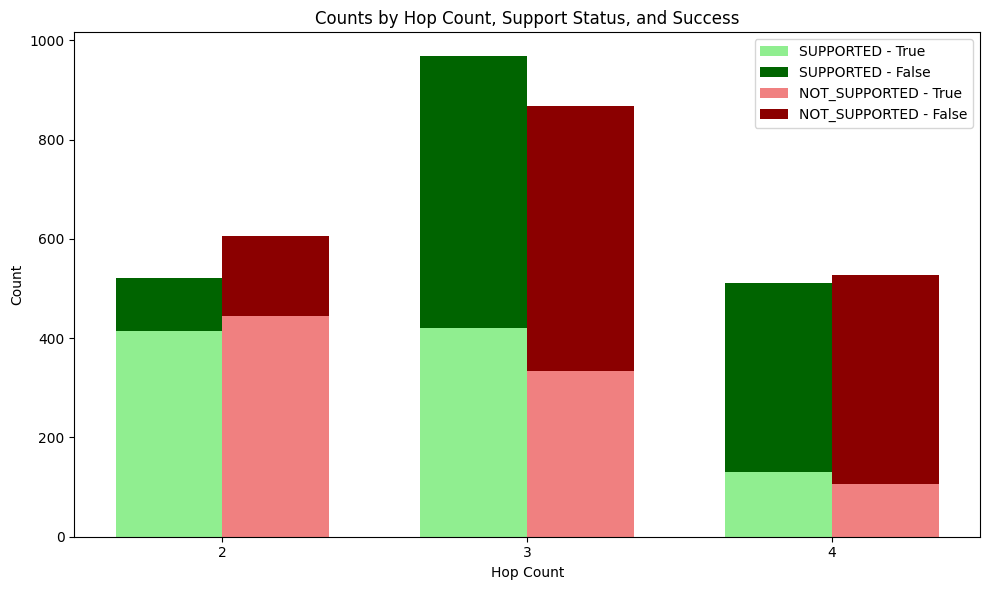

In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../").resolve()))
import pandas as pd
pd.set_option('display.max_colwidth', None)
from evaluate_retrieval import is_successful_retrieval
from utils import load_obj, save_obj
import base64
from prompt_templates import *
from qualitative_analysis_utils import calculate_success_percentage_qa, plot_retrieval_success, create_html_report

data_to_load = "/home/sander/code/thesis/hover/leon/data/decomp_baseline_FULL_DATASET_0.json"


plot_save_path = "qualitative_analysis_plot.png"
html_save_path = 'decomp_baseline_full_9shot.html'
escaped_prompt_template = decompose_9shot_instruct.replace("<", "&lt;").replace(">", "&gt;")
#escaped_prompt_template = "No Prompt Template"

retrieval_key = "decomposed_claims_retrieval_100_mistral_no_filter"
base_retrieval_key = "retrieved_0"
decomposed_claims_key = "decomposed_claims_0"
data = load_obj(data_to_load)



tpl_list = []
for hop_count in data:
    for key in data[hop_count]:
        for item in data[hop_count][key]:
            #item["retrieved"].extend(item["base_retrieved"])
            #item["retrieved"] = item["base_retrieved"]
            item["decomposed_claims"] = "None"
            found = []
            not_found = []
            not_found_base = []
            for fact in item["supporting_facts"]:
                if fact[0] in item[retrieval_key]:
                    found.append(fact[0])
                else:
                    not_found.append(fact[0])
                if fact[0] not in item[base_retrieval_key]:
                    not_found_base.append(fact[0])
            tpl_list.append((item["claim_0"],item[decomposed_claims_key],item["supporting_facts"],found,not_found_base,not_found,hop_count, key, is_successful_retrieval(item, retrieval_key=retrieval_key),item[retrieval_key]))

df = pd.DataFrame(tpl_list, columns=[ "claim", decomposed_claims_key,  "supporting_facts", "found","not_found_base","not_found","Hop Count", "Supported", "Successful Retrieval", "Retrieved Documents"])
#df_vis = pd.DataFrame(tpl_list, columns=["Hop Count", "Supported", "Successful Retrieval"])

two_hop_accuracy , three_hop_accuracy, four_hop_accuracy, average_total_accuracy = calculate_success_percentage_qa(data, retrieval_key)



plot_retrieval_success(df, plot_save_path, show_plot=False)

with open(plot_save_path, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()

def preprocess_supporting_facts(facts_list):  
    #html_list = ''.join(f'<li>{fact[0]} (sl: {fact[1]})</li>' for fact in facts_list)
    html_list = ''.join(f'<li>{fact[0]}</li>' for fact in facts_list)
    return f"<ul>{html_list}</ul>"

def preprocess_decomposed_claims(claims):
    html_list =  ''.join(f'<li>{claim}</li>' for claim in claims if claim.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_list_column(list_items):
    if not list_items or all(not item.strip() for item in list_items):
        return ""
    html_list = ''.join(f'<li>{item}</li>' for item in list_items)
    return f"<ul>{html_list}</ul>"

df['supporting_facts'] = df['supporting_facts'].apply(preprocess_supporting_facts)
df[decomposed_claims_key] = df[decomposed_claims_key].apply(preprocess_decomposed_claims)
df['found'] = df['found'].apply(preprocess_list_column)
df['not_found_base'] = df['not_found_base'].apply(preprocess_list_column)
df['not_found'] = df['not_found'].apply(preprocess_list_column)
df['Retrieved Documents'] = df['Retrieved Documents'].apply(preprocess_list_column)

create_html_report(df, two_hop_accuracy, three_hop_accuracy, four_hop_accuracy, average_total_accuracy, encoded_string, html_save_path, escaped_prompt_template, decomposed_claims_key)


In [ ]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../").resolve()))
import pandas as pd
pd.set_option('display.max_colwidth', None)
from evaluate_retrieval import is_successful_retrieval
from utils import load_obj, save_obj
import base64
from prompt_templates import *
import numpy as np
import matplotlib.pyplot as plt

data_to_load = "../decomposed_enriched_qualitative_analysis_retrieval_10_3shot_instruct.json"
retrieval_key = "retrieved_decomposed_with_context"
data = load_obj(data_to_load)


def calculate_success_percentage(data, retrieval_key):
    hop_counts = {2: {'total': 0, 'successful': 0},
                    3: {'total': 0, 'successful': 0},
                    4: {'total': 0, 'successful': 0}}


    for hop_count in data:
        int_hop_count = int(hop_count)
        for key in data[hop_count]:
            for item in data[hop_count][key]:
                #if obj["label"] == "SUPPORTED":
                hop_counts[int_hop_count]["total"] += 1
                if is_successful_retrieval(item, retrieval_key=retrieval_key):
                    hop_counts[int_hop_count]['successful'] += 1

    success_percentages = {}
    for num_hops, counts in hop_counts.items():
        if counts['total'] > 0:
            success_percentage = (counts['successful'] / counts['total']) * 100
            success_percentages[num_hops] = success_percentage


    average_total_percentage = (success_percentages[2] + success_percentages[3] + success_percentages[4]) / 3
    # Example variables
    hops_2 = round(success_percentages[2],2)
    hops_3 = round(success_percentages[3],2)
    hops_4 = round(success_percentages[4],2)
    avg_total = round(average_total_percentage,2)
    return hops_2, hops_3, hops_4, avg_total

calculate_success_percentage(data, retrieval_key)


In [ ]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../").resolve()))
import pandas as pd
pd.set_option('display.max_colwidth', None)
from evaluate_retrieval import is_successful_retrieval
from utils import load_obj, save_obj
import base64
from prompt_templates import *
from qualitative_analysis_utils import calculate_success_percentage_qa, plot_retrieval_success, create_html_report

#data_to_load = "/home/sander/code/thesis/hover/leon/data/iterative_test2.json"
data_to_load = "../data/iterative_FULL_DATASET_with_questions_60_no_filter.json"
data = load_obj(data_to_load)
html_save_path = 'base_iteration_analysi_full_dataset.html'

def create_html_report2(df,html_save_path):
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Retrieval Data Analysis</title>
    <style>
    body {font-family: Arial, sans-serif;}
    .expandable-content {margin-bottom: 10px;}
    .expandable-content .content {display: none;}
    .expandable-content .toggle-button {cursor: pointer; color: #007bff; text-decoration: underline;}
    img {max-width: 100%; height: auto;}
    table {width: 100%; border-collapse: collapse; table-layout: fixed;}
    th, td {border: 1px solid #ddd; padding: 8px; text-align: left;}
    th {background-color: #f2f2f2; position: sticky; top: 0; z-index: 10;}
    .table-container {max-height: 900px; overflow-y: visible; overflow-x: auto;border: 1px solid #ddd;}
    .claim-column {width: 300px;}
    </style>
    <script>
    function toggleContent(id) {
    var content = document.getElementById('content-' + id);
    var button = document.getElementById('button-' + id);
    if (content.style.display === 'none') {
        content.style.display = 'block';
        button.textContent = 'Collapse';
    } else {
        content.style.display = 'none';
        button.textContent = 'Expand';
    }
    }
    </script>
    </head>
    <body>

    <h2>Data Analysis</h2>
    <div class="table-container">
    <table>
    <tr>
    
        <th style="width: 50px;">Index</th>
        <th class="claim-column">Claim_0</th>
        <th style="width: 75px;">Supported</th>
        <th style="width: 75px;">Supporting Facts</th>
        <th style="width: 50px;">Hop Count</th>
        <th style="width: 75px;">Found_0</th>
        <th style="width: 75px;">Not Found_0</th>
    """
    for i in range(1,5):
        html_content += f"""
            <th class="claim-column">Claim_{i}</th>
            <th style="width: 75px;">Found_{i}</th>
            <th style="width: 75px;">Not Found_{i}</th>
        """

    html_content += "</tr>"

    for index, row in df.iterrows():
        html_content += f"""
    
    <tr>
        <td>{index + 1}</td>
        <td>{row['claim_0']}</td>
        <td>{row['Supported']}</td>
        <td>{row['supporting_facts']}</td>
        <td>{row['Hop Count']}</td>

        <td>{row['found_0']}</td>
        <td>{row['not_found_0']}</td>
        <td>{row['claim_1']}</td>
        <td>{row['found_1']}</td>
        <td>{row['not_found_1']}</td>
        <td>{row['claim_2']}</td>
        <td>{row['found_2']}</td>
        <td>{row['not_found_2']}</td>
        <td>{row['claim_3']}</td>
        <td>{row['found_3']}</td>
        <td>{row['not_found_3']}</td>
        <td>{row['claim_4']}</td>
        <td>{row['found_4']}</td>
        <td>{row['not_found_4']}</td>



    </tr>
    """
    
    html_content += """
        </table>
    </div>
    </body>
    </html>
    """

    #        <td>{row['claim_5']}</td>
        #<td>{row['found_5']}</td>
        #<td>{row['not_found_5']}</td>
    with open(html_save_path, 'w') as file:
        file.write(html_content)

tpl_list = []
for hop_count in data:
    for key in data[hop_count]:
        for item in data[hop_count][key]:
            #item["retrieved"].extend(item["base_retrieved"])
            #item["retrieved"] = item["base_retrieved"]
            found_dict = {}
            for i in range(0,5):
                if i > int(hop_count):
                    found_dict[f"found_{i}"] = [""]
                    found_dict[f"not_found_{i}"] = [""]
                    item[f"claim_{i}"] = ""
                else:
                    found_dict[f"found_{i}"] = []
                    found_dict[f"not_found_{i}"] = []

            for i in range(0,5):
                for fact in item["supporting_facts"]:
                    if i <= int(hop_count):
                        if fact[0] in item[f"retrieved_{i}"]:
                            found_dict[f"found_{i}"].append(fact[0])
                        else:
                            found_dict[f"not_found_{i}"].append(fact[0])

            tpl_list.append((item["claim_0"],item["supporting_facts"],hop_count, key, found_dict["found_0"],found_dict["not_found_0"],
                             item["claim_1"],found_dict["found_1"],found_dict["not_found_1"],
                             item["claim_2"], found_dict["found_2"], found_dict["not_found_2"],
                                item["claim_3"], found_dict["found_3"], found_dict["not_found_3"],
                                item["claim_4"], found_dict["found_4"], found_dict["not_found_4"],))
                                #item["claim_5"], found_dict["found_5"], found_dict["not_found_5"]))

df = pd.DataFrame(tpl_list, columns=[ "claim_0", "supporting_facts", "Hop Count", "Supported", "found_0","not_found_0","claim_1", "found_1","not_found_1","claim_2", "found_2", "not_found_2",
 "claim_3", "found_3", "not_found_3",
 "claim_4", "found_4", "not_found_4",])
 #"claim_5", "found_5", "not_found_5" ])
#df_vis = pd.DataFrame(tpl_list, columns=["Hop Count", "Supported", "Successful Retrieval"])


def preprocess_supporting_facts(facts_list):  
    html_list = ''.join(f'<li>{fact[0]} (sl: {fact[1]})</li>' for fact in facts_list)
    return f"<ul>{html_list}</ul>"

def preprocess_decomposed_claims(claims):
    claims_list = claims.split("\n")
    html_list =  ''.join(f'<li>{claim.strip()}</li>' for claim in claims_list if claim.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_list_column(list_items):
    html_list = ''.join(f'<li>{item}</li>' for item in list_items)
    return f"<ul>{html_list}</ul>"

df['supporting_facts'] = df['supporting_facts'].apply(preprocess_supporting_facts)
df['found_0'] = df['found_0'].apply(preprocess_list_column)
df['not_found_0'] = df['not_found_0'].apply(preprocess_list_column)
df['found_1'] = df['found_1'].apply(preprocess_list_column)
df['not_found_1'] = df['not_found_1'].apply(preprocess_list_column)

df['found_2'] = df['found_2'].apply(preprocess_list_column)
df['not_found_2'] = df['not_found_2'].apply(preprocess_list_column)

df['found_3'] = df['found_3'].apply(preprocess_list_column)
df['not_found_3'] = df['not_found_3'].apply(preprocess_list_column)

df['found_4'] = df['found_4'].apply(preprocess_list_column)
df['not_found_4'] = df['not_found_4'].apply(preprocess_list_column)

#df['found_5'] = df['found_5'].apply(preprocess_list_column)
#df['not_found_5'] = df['not_found_5'].apply(preprocess_list_column)

create_html_report2(df,html_save_path)

In [ ]:
df

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd

def parse_html_to_set(html_str):
    """ Parses HTML formatted string to extract list items into a set. """
    soup = BeautifulSoup(html_str, "html.parser")
    items = {li.get_text() for li in soup.find_all("li")}
    return items

def check_found_superset(df_row, base_col='found_0'):
    results = []
    base_set = parse_html_to_set(df_row[base_col])  # Use custom parser for the base column
    for i in range(1, 5):
        found_col = f'found_{i}'
        claim_col = f'claim_{i}'
        if df_row[claim_col] != "":  # Check if claim_i is not empty
            compare_set = parse_html_to_set(df_row[found_col])  # Use custom parser for the found_i column
            if base_set.issubset(compare_set) and len(compare_set) > len(base_set):
                results.append(True)
            else:
                results.append(False)
        else:
            results.append(None)  # None for non-applicable cases
    return results


# Apply the function to each row in the DataFrame
results = df.apply(check_found_superset, axis=1)
results_df = pd.DataFrame(results.tolist(), columns=['is_superset_1', 'is_superset_2', 'is_superset_3', 'is_superset_4'])

# Calculate the percentage of True values for each claim comparison
percentages = {f'Percentage Superset {i}': 100 * results_df[f'is_superset_{i}'].dropna().mean() for i in range(1, 5)}

print(percentages)


In [ ]:
parse_html_to_set(df.iloc[0]['found_3'])

In [ ]:
base_set = [""]
compare_set = ["test"]
if base_set.issubset(compare_set) and len(compare_set) > len(base_set):
        print(True)
else:
    print(False)

In [ ]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../").resolve()))
import pandas as pd
pd.set_option('display.max_colwidth', None)
from evaluate_retrieval import is_successful_retrieval
from utils import load_obj, save_obj
import base64
from prompt_templates import *
from qualitative_analysis_utils import calculate_success_percentage_qa, plot_retrieval_success, create_html_report

data_to_load = "../data/iterative_qualitative_analysis_not_supported_filter_60.json"
data = load_obj(data_to_load)
html_save_path = 'not_supported_analysis.html'

def create_html_report2(df,html_save_path):
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Retrieval Data Analysis</title>
    <style>
    body {font-family: Arial, sans-serif;}
    .expandable-content {margin-bottom: 10px;}
    .expandable-content .content {display: none;}
    .expandable-content .toggle-button {cursor: pointer; color: #007bff; text-decoration: underline;}
    img {max-width: 100%; height: auto;}
    table {width: 100%; border-collapse: collapse; table-layout: fixed;}
    th, td {border: 1px solid #ddd; padding: 8px; text-align: left;}
    th {background-color: #f2f2f2; position: sticky; top: 0; z-index: 10;}
    .table-container {max-height: 900px; overflow-y: visible; overflow-x: auto;border: 1px solid #ddd;}
    .claim-column {width: 300px;}
    </style>
    <script>
    function toggleContent(id) {
    var content = document.getElementById('content-' + id);
    var button = document.getElementById('button-' + id);
    if (content.style.display === 'none') {
        content.style.display = 'block';
        button.textContent = 'Collapse';
    } else {
        content.style.display = 'none';
        button.textContent = 'Expand';
    }
    }
    </script>
    </head>
    <body>

    <h2>Data Analysis</h2>
    <div class="table-container">
    <table>
    <tr>
    
        <th style="width: 50px;">Index</th>
        <th class="claim-column">Claim_0</th>
        <th style="width: 75px;">Supported</th>
        <th style="width: 75px;">Supporting Facts</th>
        <th style="width: 50px;">Hop Count</th>
        <th style="width: 75px;">Found_0</th>
        <th style="width: 75px;">Not Found_0</th>
    """
    for i in range(1,5):
        html_content += f"""
            <th class="claim-column">Claim_{i}</th>
            <th style="width: 75px;">Found_{i}</th>
            <th style="width: 75px;">Not Found_{i}</th>
        """

    html_content += "</tr>"

    for index, row in df.iterrows():
        html_content += f"""
    
    <tr>
        <td>{index + 1}</td>
        <td>{row['claim_0']}</td>
        <td>{row['Supported']}</td>
        <td>{row['supporting_facts']}</td>
        <td>{row['Hop Count']}</td>

        <td>{row['found_0']}</td>
        <td>{row['not_found_0']}</td>
        <td>{row['claim_1']}</td>
        <td>{row['found_1']}</td>
        <td>{row['not_found_1']}</td>
        <td>{row['claim_2']}</td>
        <td>{row['found_2']}</td>
        <td>{row['not_found_2']}</td>
        <td>{row['claim_3']}</td>
        <td>{row['found_3']}</td>
        <td>{row['not_found_3']}</td>
        <td>{row['claim_4']}</td>
        <td>{row['found_4']}</td>
        <td>{row['not_found_4']}</td>



    </tr>
    """
    
    html_content += """
        </table>
    </div>
    </body>
    </html>
    """

    #        <td>{row['claim_5']}</td>
        #<td>{row['found_5']}</td>
        #<td>{row['not_found_5']}</td>
    with open(html_save_path, 'w') as file:
        file.write(html_content)

tpl_list = []
for hop_count in data:

    for item in data[hop_count]:
        #item["retrieved"].extend(item["base_retrieved"])
        #item["retrieved"] = item["base_retrieved"]
        found_dict = {}
        for i in range(0,6):
            if i > int(hop_count):
                found_dict[f"found_{i}"] = [""]
                found_dict[f"not_found_{i}"] = [""]
                item[f"claim_{i}"] = ""
            else:
                found_dict[f"found_{i}"] = []
                found_dict[f"not_found_{i}"] = []

        for i in range(0,6):
            for fact in item["supporting_facts"]:
                if i <= int(hop_count):
                    if fact[0] in item[f"retrieved_{i}"]:
                        found_dict[f"found_{i}"].append(fact[0])
                    else:
                        found_dict[f"not_found_{i}"].append(fact[0])

        tpl_list.append((item["claim_0"],item["supporting_facts"],hop_count, "1", found_dict["found_0"],found_dict["not_found_0"],
                            item["claim_1"],found_dict["found_1"],found_dict["not_found_1"],
                            item["claim_2"], found_dict["found_2"], found_dict["not_found_2"],
                            item["claim_3"], found_dict["found_3"], found_dict["not_found_3"],
                            item["claim_4"], found_dict["found_4"], found_dict["not_found_4"],
                            item["claim_5"], found_dict["found_5"], found_dict["not_found_5"]))


        found_dict = {}
        for i in range(0,6):
            if i > int(hop_count):
                found_dict[f"found_{i}"] = [""]
                found_dict[f"not_found_{i}"] = [""]
                item["not_supported_counterpart"][f"claim_{i}"] = ""
            else:
                found_dict[f"found_{i}"] = []
                found_dict[f"not_found_{i}"] = []

        for i in range(0,6):
            for fact in item["not_supported_counterpart"]["supporting_facts"]:
                if i <= int(hop_count):
                    if fact[0] in item["not_supported_counterpart"][f"retrieved_{i}"]:
                        found_dict[f"found_{i}"].append(fact[0])
                    else:
                        found_dict[f"not_found_{i}"].append(fact[0])

        tpl_list.append((item["not_supported_counterpart"]["claim_0"],item["not_supported_counterpart"]["supporting_facts"],hop_count, "0", found_dict["found_0"],found_dict["not_found_0"],
                            item["not_supported_counterpart"]["claim_1"],found_dict["found_1"],found_dict["not_found_1"],
                            item["not_supported_counterpart"]["claim_2"], found_dict["found_2"], found_dict["not_found_2"],
                            item["not_supported_counterpart"]["claim_3"], found_dict["found_3"], found_dict["not_found_3"],
                            item["not_supported_counterpart"]["claim_4"], found_dict["found_4"], found_dict["not_found_4"],
                            item["not_supported_counterpart"]["claim_5"], found_dict["found_5"], found_dict["not_found_5"]))

df = pd.DataFrame(tpl_list, columns=[ "claim_0", "supporting_facts", "Hop Count", "Supported", "found_0","not_found_0","claim_1", "found_1","not_found_1","claim_2", "found_2", "not_found_2",
 "claim_3", "found_3", "not_found_3",
 "claim_4", "found_4", "not_found_4",
 "claim_5", "found_5", "not_found_5" ])
#df_vis = pd.DataFrame(tpl_list, columns=["Hop Count", "Supported", "Successful Retrieval"])


def preprocess_supporting_facts(facts_list):  
    html_list = ''.join(f'<li>{fact[0]} (sl: {fact[1]})</li>' for fact in facts_list)
    return f"<ul>{html_list}</ul>"

def preprocess_decomposed_claims(claims):
    claims_list = claims.split("\n")
    html_list =  ''.join(f'<li>{claim.strip()}</li>' for claim in claims_list if claim.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_list_column(list_items):
    html_list = ''.join(f'<li>{item}</li>' for item in list_items)
    return f"<ul>{html_list}</ul>"

df['supporting_facts'] = df['supporting_facts'].apply(preprocess_supporting_facts)
df['found_0'] = df['found_0'].apply(preprocess_list_column)
df['not_found_0'] = df['not_found_0'].apply(preprocess_list_column)
df['found_1'] = df['found_1'].apply(preprocess_list_column)
df['not_found_1'] = df['not_found_1'].apply(preprocess_list_column)

df['found_2'] = df['found_2'].apply(preprocess_list_column)
df['not_found_2'] = df['not_found_2'].apply(preprocess_list_column)

df['found_3'] = df['found_3'].apply(preprocess_list_column)
df['not_found_3'] = df['not_found_3'].apply(preprocess_list_column)

df['found_4'] = df['found_4'].apply(preprocess_list_column)
df['not_found_4'] = df['not_found_4'].apply(preprocess_list_column)

df['found_5'] = df['found_5'].apply(preprocess_list_column)
df['not_found_5'] = df['not_found_5'].apply(preprocess_list_column)

create_html_report2(df,html_save_path)

In [ ]:
# with subquestions
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../").resolve()))
import pandas as pd
pd.set_option('display.max_colwidth', None)
from evaluate_retrieval import is_successful_retrieval
from utils import load_obj, save_obj
import base64
from prompt_templates import *
from qualitative_analysis_utils import calculate_success_percentage_qa, plot_retrieval_success, create_html_report

data_to_load = "../data/iterative_FULL_DATASET_with_questions_NEW2.json"
data = load_obj(data_to_load)
html_save_path = 'full_iterative_decomp.html'

def create_html_report2(df,html_save_path):
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Retrieval Data Analysis</title>
    <style>
    body {font-family: Arial, sans-serif;}
    .expandable-content {margin-bottom: 10px;}
    .expandable-content .content {display: none;}
    .expandable-content .toggle-button {cursor: pointer; color: #007bff; text-decoration: underline;}
    img {max-width: 100%; height: auto;}
    table {width: 100%; border-collapse: collapse; table-layout: fixed;}
    th, td {border: 1px solid #ddd; padding: 8px; text-align: left;}
    th {background-color: #f2f2f2; position: sticky; top: 0; z-index: 10;}
    .table-container {max-height: 900px; overflow-y: visible; overflow-x: auto;border: 1px solid #ddd;}
    .claim-column {width: 300px;}
    ul {padding-left: 0; list-style-position: inside;}
    </style>
    <script>
    function toggleContent(id) {
    var content = document.getElementById('content-' + id);
    var button = document.getElementById('button-' + id);
    if (content.style.display === 'none') {
        content.style.display = 'block';
        button.textContent = 'Collapse';
    } else {
        content.style.display = 'none';
        button.textContent = 'Expand';
    }
    }
    </script>
    </head>
    <body>

    <h2>Data Analysis</h2>
    <div class="table-container">
    <table>
    <tr>
    
        <th style="width: 50px;">Index</th>
        <th class="claim-column">Claim_0</th>
        <th style="width: 75px;">Supported</th>
        <th style="width: 75px;">Supporting Facts</th>
        <th style="width: 50px;">Hop Count</th>
        <th style="width: 75px;">Found_0</th>
        <th style="width: 75px;">Not Found_0</th>
        <th class="claim-column">Sub Questions_0</th>
    """
    for i in range(1,5):
        html_content += f"""
            <th class="claim-column">Claim_{i}</th>
            <th style="width: 75px;">Found_{i}</th>
            <th style="width: 75px;">Not Found_{i}</th>
            <th class="claim-column">Sub Questions_{i}</th>
        """

    html_content += "</tr>"

    for index, row in df.iterrows():
        html_content += f"""
    
    <tr>
        <td>{index + 1}</td>
        <td>{row['claim_0']}</td>
        <td>{row['Supported']}</td>
        <td>{row['supporting_facts']}</td>
        <td>{row['Hop Count']}</td>

        <td>{row['found_0']}</td>
        <td>{row['not_found_0']}</td>
        <td>{row['sub_questions_0']}</td>
        <td>{row['claim_1']}</td>
        <td>{row['found_1']}</td>
        <td>{row['not_found_1']}</td>
        <td>{row['sub_questions_1']}</td>
        <td>{row['claim_2']}</td>
        <td>{row['found_2']}</td>
        <td>{row['not_found_2']}</td>
        <td>{row['sub_questions_2']}</td>
        <td>{row['claim_3']}</td>
        <td>{row['found_3']}</td>
        <td>{row['not_found_3']}</td>
        <td>{row['sub_questions_3']}</td>
        <td>{row['claim_4']}</td>
        <td>{row['found_4']}</td>
        <td>{row['not_found_4']}</td>
        <td>{row['sub_questions_4']}</td>



    </tr>
    """
    
    html_content += """
        </table>
    </div>
    </body>
    </html>
    """

    #        <td>{row['claim_5']}</td>
        #<td>{row['found_5']}</td>
        #<td>{row['not_found_5']}</td>
    with open(html_save_path, 'w') as file:
        file.write(html_content)

tpl_list = []
for hop_count in data:

    for item in data[hop_count]:
        #item["retrieved"].extend(item["base_retrieved"])
        #item["retrieved"] = item["base_retrieved"]
        found_dict = {}
        for i in range(0,6):
            if i > int(hop_count):
                found_dict[f"found_{i}"] = [""]
                found_dict[f"not_found_{i}"] = [""]
                item[f"claim_{i}"] = ""
                item[f"sub_questions_{i}"] = ""
            else:
                found_dict[f"found_{i}"] = []
                found_dict[f"not_found_{i}"] = []

        for i in range(0,6):
            for fact in item["supporting_facts"]:
                if i <= int(hop_count):
                    if fact[0] in item[f"retrieved_{i}"]:
                        found_dict[f"found_{i}"].append(fact[0])
                    else:
                        found_dict[f"not_found_{i}"].append(fact[0])

        tpl_list.append((item["claim_0"],item["supporting_facts"],hop_count, "1", found_dict["found_0"],found_dict["not_found_0"],item["sub_questions_0"],
                            item["claim_1"],found_dict["found_1"],found_dict["not_found_1"],item["sub_questions_1"],
                            item["claim_2"], found_dict["found_2"], found_dict["not_found_2"],item["sub_questions_2"],
                            item["claim_3"], found_dict["found_3"], found_dict["not_found_3"],item["sub_questions_3"],
                            item["claim_4"], found_dict["found_4"], found_dict["not_found_4"],item["sub_questions_4"],
                            item["claim_5"], found_dict["found_5"], found_dict["not_found_5"]))


        found_dict = {}
        for i in range(0,6):
            if i > int(hop_count):
                found_dict[f"found_{i}"] = [""]
                found_dict[f"not_found_{i}"] = [""]
                item["not_supported_counterpart"][f"claim_{i}"] = ""
                item["not_supported_counterpart"][f"sub_questions_{i}"] = ""
            else:
                found_dict[f"found_{i}"] = []
                found_dict[f"not_found_{i}"] = []

        for i in range(0,6):
            for fact in item["not_supported_counterpart"]["supporting_facts"]:
                if i <= int(hop_count):
                    if fact[0] in item["not_supported_counterpart"][f"retrieved_{i}"]:
                        found_dict[f"found_{i}"].append(fact[0])
                    else:
                        found_dict[f"not_found_{i}"].append(fact[0])

        tpl_list.append((item["not_supported_counterpart"]["claim_0"],item["not_supported_counterpart"]["supporting_facts"],hop_count, "0", found_dict["found_0"],found_dict["not_found_0"],item["not_supported_counterpart"]["sub_questions_0"],
                            item["not_supported_counterpart"]["claim_1"],found_dict["found_1"],found_dict["not_found_1"],item["not_supported_counterpart"]["sub_questions_1"],
                            item["not_supported_counterpart"]["claim_2"], found_dict["found_2"], found_dict["not_found_2"],item["not_supported_counterpart"]["sub_questions_2"],
                            item["not_supported_counterpart"]["claim_3"], found_dict["found_3"], found_dict["not_found_3"],item["not_supported_counterpart"]["sub_questions_3"],
                            item["not_supported_counterpart"]["claim_4"], found_dict["found_4"], found_dict["not_found_4"],item["not_supported_counterpart"]["sub_questions_4"],
                            item["not_supported_counterpart"]["claim_5"], found_dict["found_5"], found_dict["not_found_5"]))

df = pd.DataFrame(tpl_list, columns=[ "claim_0", "supporting_facts", "Hop Count", "Supported", "found_0","not_found_0","sub_questions_0","claim_1", "found_1","not_found_1","sub_questions_1","claim_2", "found_2", "not_found_2","sub_questions_2",
 "claim_3", "found_3", "not_found_3","sub_questions_3",
 "claim_4", "found_4", "not_found_4","sub_questions_4",
 "claim_5", "found_5", "not_found_5" ])
#df_vis = pd.DataFrame(tpl_list, columns=["Hop Count", "Supported", "Successful Retrieval"])


def preprocess_supporting_facts(facts_list):  
    html_list = ''.join(f'<li>{fact[0]} (sl: {fact[1]})</li>' for fact in facts_list)
    return f"<ul>{html_list}</ul>"

def preprocess_decomposed_claims(claims):
    claims_list = claims.split("\n")
    html_list =  ''.join(f'<li>{claim.strip()}</li>' for claim in claims_list if claim.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_sub_questions(sub_questions_list):
    html_list =  ''.join(f'<li>{sub_question.strip()}</li>' for sub_question in sub_questions_list if sub_question.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_list_column(list_items):
    html_list = ''.join(f'<li>{item}</li>' for item in list_items)
    return f"<ul>{html_list}</ul>"

df['supporting_facts'] = df['supporting_facts'].apply(preprocess_supporting_facts)
df['found_0'] = df['found_0'].apply(preprocess_list_column)
df['not_found_0'] = df['not_found_0'].apply(preprocess_list_column)
df["sub_questions_0"] = df["sub_questions_0"].apply(preprocess_sub_questions)

df['found_1'] = df['found_1'].apply(preprocess_list_column)
df['not_found_1'] = df['not_found_1'].apply(preprocess_list_column)
df["sub_questions_1"] = df["sub_questions_1"].apply(preprocess_sub_questions)

df['found_2'] = df['found_2'].apply(preprocess_list_column)
df['not_found_2'] = df['not_found_2'].apply(preprocess_list_column)
df["sub_questions_2"] = df["sub_questions_2"].apply(preprocess_sub_questions)

df['found_3'] = df['found_3'].apply(preprocess_list_column)
df['not_found_3'] = df['not_found_3'].apply(preprocess_list_column)
df["sub_questions_3"] = df["sub_questions_3"].apply(preprocess_sub_questions)

df['found_4'] = df['found_4'].apply(preprocess_list_column)
df['not_found_4'] = df['not_found_4'].apply(preprocess_list_column)
df["sub_questions_4"] = df["sub_questions_4"].apply(preprocess_sub_questions)

df['found_5'] = df['found_5'].apply(preprocess_list_column)
df['not_found_5'] = df['not_found_5'].apply(preprocess_list_column)

create_html_report2(df,html_save_path)

In [ ]:
def calculate_success_percentage(data, retrieval_key):
    hop_counts = {2: {'total': 0, 'successful': 0},
                    3: {'total': 0, 'successful': 0},
                    4: {'total': 0, 'successful': 0}}


    for hop_count in data:
        int_hop_count = int(hop_count)
        for item in data[hop_count]:
            #if obj["label"] == "SUPPORTED":
            hop_counts[int_hop_count]["total"] += 1
            if is_successful_retrieval(item, retrieval_key=retrieval_key):
                hop_counts[int_hop_count]['successful'] += 1

    success_percentages = {}
    for num_hops, counts in hop_counts.items():
        if counts['total'] > 0:
            success_percentage = (counts['successful'] / counts['total']) * 100
            success_percentages[num_hops] = success_percentage


    average_total_percentage = (success_percentages[2] + success_percentages[3] + success_percentages[4]) / 3
    # Example variables
    hops_2 = round(success_percentages[2],2)
    hops_3 = round(success_percentages[3],2)
    hops_4 = round(success_percentages[4],2)
    avg_total = round(average_total_percentage,2)
    return hops_2, hops_3, hops_4, avg_total

def calculate_success_percentage_not_supp(data, retrieval_key):
    hop_counts = {2: {'total': 0, 'successful': 0},
                    3: {'total': 0, 'successful': 0},
                    4: {'total': 0, 'successful': 0}}


    for hop_count in data:
        int_hop_count = int(hop_count)
        for item in data[hop_count]:
            #if obj["label"] == "SUPPORTED":
            hop_counts[int_hop_count]["total"] += 1
            if is_successful_retrieval(item["not_supported_counterpart"], retrieval_key=retrieval_key):
                hop_counts[int_hop_count]['successful'] += 1

    success_percentages = {}
    for num_hops, counts in hop_counts.items():
        if counts['total'] > 0:
            success_percentage = (counts['successful'] / counts['total']) * 100
            success_percentages[num_hops] = success_percentage


    average_total_percentage = (success_percentages[2] + success_percentages[3] + success_percentages[4]) / 3
    # Example variables
    hops_2 = round(success_percentages[2],2)
    hops_3 = round(success_percentages[3],2)
    hops_4 = round(success_percentages[4],2)
    avg_total = round(average_total_percentage,2)
    return hops_2, hops_3, hops_4, avg_total

calculate_success_percentage_not_supp(data, retrieval_key="")

In [2]:
# with subquestions
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../").resolve()))
from utils import load_obj

#data_to_load = "../data/iterative_qualitative_analysis_not_supported_filter_60.json"
data_to_load = "../data/iterative_decomp_FULL_DATASET_1.json"
data = load_obj(data_to_load)
print(data["4"]["SUPPORTED"][0].keys())

dict_keys(['uid', 'supporting_facts', 'label', 'num_hops', 'hpqa_id', 'previous_iteration_sentences', 'claim_0', 'retrieved_0', 'sub_questions_0', 'sub_question_retrieval_0', 'sub_question_sentences_0', 'top_sentences_0', 'claim_1', 'retrieved_1', 'sub_questions_1', 'sub_question_retrieval_1', 'sub_question_sentences_1', 'top_sentences_1', 'claim_2', 'retrieved_2', 'sub_questions_2', 'sub_question_retrieval_2', 'sub_question_sentences_2', 'top_sentences_2', 'claim_3', 'sub_questions_3', 'sub_question_retrieval_3', 'sub_question_sentences_3', 'top_sentences_3', 'claim_4', 'retrieved_3', 'retrieved_4', 'decomposed_claims_0', 'decomposed_claims_retrieval_0', 'decomposed_claims_1', 'decomposed_claims_retrieval_1', 'decomposed_claims_2', 'decomposed_claims_retrieval_2', 'decomposed_claims_3', 'decomposed_claims_retrieval_3', 'decomposed_claims_4', 'decomposed_claims_retrieval_4', 'decomposed_claims_retrieval_100_combined_0', 'decomposed_claims_retrieval_100_combined_1', 'decomposed_claims_r

In [8]:
# with subquestions
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../").resolve()))
import pandas as pd
pd.set_option('display.max_colwidth', None)
from evaluate_retrieval import is_successful_retrieval
from utils import load_obj, save_obj
import base64
from prompt_templates import *
from qualitative_analysis_utils import calculate_success_percentage_qa, plot_retrieval_success, create_html_report

#data_to_load = "../data/iterative_qualitative_analysis_not_supported_filter_60.json"
data_to_load = "../data/iterative_decomp_FULL_DATASET_1.json"
data = load_obj(data_to_load)
html_save_path = 'decomp1_full_data.html'

def create_html_report2(df,html_save_path):
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Retrieval Data Analysis</title>
    <style>
    body {font-family: Arial, sans-serif;}
    .expandable-content {margin-bottom: 10px;}
    .expandable-content .content {display: none;}
    .expandable-content .toggle-button {cursor: pointer; color: #007bff; text-decoration: underline;}
    img {max-width: 100%; height: auto;}
    table {width: 100%; border-collapse: collapse; table-layout: fixed;}
    th, td {border: 1px solid #ddd; padding: 8px; text-align: left;}
    th {background-color: #f2f2f2; position: sticky; top: 0; z-index: 10;}
    .table-container {max-height: 900px; overflow-y: visible; overflow-x: auto;border: 1px solid #ddd;}
    .claim-column {width: 300px;}
    ul {padding-left: 0; list-style-position: inside;}
    </style>
    <script>
    function toggleContent(id) {
    var content = document.getElementById('content-' + id);
    var button = document.getElementById('button-' + id);
    if (content.style.display === 'none') {
        content.style.display = 'block';
        button.textContent = 'Collapse';
    } else {
        content.style.display = 'none';
        button.textContent = 'Expand';
    }
    }
    </script>
    </head>
    <body>

    <h2>Data Analysis</h2>
    <div class="table-container">
    <table>
    <tr>
    
        <th style="width: 50px;">Index</th>
        <th style="width: 75px;">Supported</th>
        <th style="width: 75px;">Supporting Facts</th>
        <th style="width: 50px;">Hop Count</th>
        <th class="claim-column">Claim_0</th>
        <th style="width: 75px;">not_found_baseline</th>
    """
    for i in range(1,5):
        html_content += f"""
            <th class="claim-column">Claim_{i}</th>
            <th class="claim-column">Decomp_{i}</th>
            <th style="width: 75px;">Decomp Not Found_{i}</th>
        """

    html_content += "</tr>"

    for index, row in df.iterrows():
        html_content += f"""
    
    <tr>
        <td>{index + 1}</td>
        
        <td>{row['Supported']}</td>
        <td>{row['supporting_facts']}</td>
        <td>{row['Hop Count']}</td>

        <td>{row['claim_0']}</td>
        <td>{row['not_found_baseline']}</td>

        <td>{row['claim_1']}</td>
        <td>{row['decomp_1']}</td>
        <td>{row['not_found_1']}</td>

        <td>{row['claim_2']}</td>
        <td>{row['decomp_2']}</td>
        <td>{row['not_found_2']}</td>

        <td>{row['claim_3']}</td>
        <td>{row['decomp_3']}</td>
        <td>{row['not_found_3']}</td>

        <td>{row['claim_4']}</td>
        <td>{row['decomp_4']}</td>
        <td>{row['not_found_4']}</td>
        



    </tr>
    """
    
    html_content += """
        </table>
    </div>
    </body>
    </html>
    """

    #        <td>{row['claim_5']}</td>
        #<td>{row['found_5']}</td>
        #<td>{row['not_found_5']}</td>
    with open(html_save_path, 'w') as file:
        file.write(html_content)

tpl_list = []
for hop_count in data:
    for key in data[hop_count]:
        for item in data[hop_count][key]:
            #item["retrieved"].extend(item["base_retrieved"])
            #item["retrieved"] = item["base_retrieved"]
            found_dict = {}
            for i in range(0,5):
                if i == 0:
                    found_dict["not_found_baseline"] = []
                if i > int(hop_count):
                    found_dict[f"not_found_{i}"] = [""]
                    item[f"claim_{i}"] = ""
                    item[f"decomposed_claims_{i}"] = ""
                else:
                    found_dict[f"found_{i}"] = []
                    found_dict[f"not_found_{i}"] = []

            for i in range(0,5):
                for fact in item["supporting_facts"]:
                    if i <= int(hop_count):
                        if fact[0] not in item[f"decomposed_claims_retrieval_100_combined_{i}"]:
                            found_dict[f"not_found_{i}"].append(fact[0])
                    if i == 0:
                        if fact[0] not in item["retrieved_0"]:
                            found_dict["not_found_baseline"].append(fact[0])

            tpl_list.append((1 if key == "SUPPORTED" else 0,item["supporting_facts"],hop_count, item["claim_0"], found_dict["not_found_baseline"],
                                item["claim_1"],item["decomposed_claims_1"], found_dict["not_found_1"],
                                item["claim_2"],  item["decomposed_claims_2"], found_dict["not_found_2"],
                                item["claim_3"],  item["decomposed_claims_3"], found_dict["not_found_3"],
                                item["claim_4"],  item["decomposed_claims_4"], found_dict["not_found_4"]))
        
df = pd.DataFrame(tpl_list, columns=["Supported","supporting_facts", "Hop Count", "claim_0", "not_found_baseline",
                                     "claim_1","decomp_1", "not_found_1","claim_2","decomp_2",  "not_found_2",
                                     "claim_3", "decomp_3", "not_found_3",
                                     "claim_4", "decomp_4", "not_found_4"])
#df_vis = pd.DataFrame(tpl_list, columns=["Hop Count", "Supported", "Successful Retrieval"])


def preprocess_supporting_facts(facts_list):  
    html_list = ''.join(f'<li>{fact[0]} (sl: {fact[1]})</li>' for fact in facts_list)
    return f"<ul>{html_list}</ul>"

def preprocess_decomposed_claims(claims):
    claims_list = claims.split("\n")
    html_list =  ''.join(f'<li>{claim.strip()}</li>' for claim in claims_list if claim.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_sub_questions(sub_questions_list):
    html_list =  ''.join(f'<li>{sub_question.strip()}</li>' for sub_question in sub_questions_list if sub_question.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_list_column(list_items):
    html_list = ''.join(f'<li>{item}</li>' for item in list_items)
    return f"<ul>{html_list}</ul>"

df['supporting_facts'] = df['supporting_facts'].apply(preprocess_supporting_facts)
#df['not_found_0'] = df['not_found_0'].apply(preprocess_list_column)
df['not_found_baseline'] = df['not_found_baseline'].apply(preprocess_list_column)
#df["decomp_0"] = df["decomp_0"].apply(preprocess_sub_questions)

df['not_found_1'] = df['not_found_1'].apply(preprocess_list_column)
df["decomp_1"] = df["decomp_1"].apply(preprocess_sub_questions)

df['not_found_2'] = df['not_found_2'].apply(preprocess_list_column)
df["decomp_2"] = df["decomp_2"].apply(preprocess_sub_questions)

df['not_found_3'] = df['not_found_3'].apply(preprocess_list_column)
df["decomp_3"] = df["decomp_3"].apply(preprocess_sub_questions)

df['not_found_4'] = df['not_found_4'].apply(preprocess_list_column)
df["decomp_4"] = df["decomp_4"].apply(preprocess_sub_questions)

create_html_report2(df,html_save_path)

In [4]:
# with subquestions
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../").resolve()))
import pandas as pd
pd.set_option('display.max_colwidth', None)
from evaluate_retrieval import is_successful_retrieval
from utils import load_obj, save_obj
import base64
from prompt_templates import *
from qualitative_analysis_utils import calculate_success_percentage_qa, plot_retrieval_success, create_html_report

#data_to_load = "../data/iterative_qualitative_analysis_not_supported_filter_60.json"
data_to_load = "../data/iterative_decomp_FULL_DATASET_1.json"
data = load_obj(data_to_load)
html_save_path = 'decomp1_subq_full_data.html'

def create_html_report2(df,html_save_path):
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Retrieval Data Analysis</title>
    <style>
    body {font-family: Arial, sans-serif;}
    .expandable-content {margin-bottom: 10px;}
    .expandable-content .content {display: none;}
    .expandable-content .toggle-button {cursor: pointer; color: #007bff; text-decoration: underline;}
    img {max-width: 100%; height: auto;}
    table {width: 100%; border-collapse: collapse; table-layout: fixed;}
    th, td {border: 1px solid #ddd; padding: 8px; text-align: left;}
    th {background-color: #f2f2f2; position: sticky; top: 0; z-index: 10;}
    .table-container {max-height: 900px; overflow-y: visible; overflow-x: auto;border: 1px solid #ddd;}
    .claim-column {width: 300px;}
    ul {padding-left: 0; list-style-position: inside;}
    </style>
    <script>
    function toggleContent(id) {
    var content = document.getElementById('content-' + id);
    var button = document.getElementById('button-' + id);
    if (content.style.display === 'none') {
        content.style.display = 'block';
        button.textContent = 'Collapse';
    } else {
        content.style.display = 'none';
        button.textContent = 'Expand';
    }
    }
    </script>
    </head>
    <body>

    <h2>Data Analysis</h2>
    <div class="table-container">
    <table>
    <tr>
    
        <th style="width: 50px;">Index</th>
        <th style="width: 75px;">Supported</th>
        <th style="width: 75px;">Supporting Facts</th>
        <th style="width: 50px;">Hop Count</th>
        <th class="claim-column">Claim_0</th>
        <th style="width: 75px;">not_found_baseline</th>
    """
    for i in range(1,5):
        html_content += f"""
            <th class="claim-column">sub_Q_{i-1}</th>
            <th class="claim-column">Claim_{i}</th>
            <th class="claim-column">Decomp_{i}</th>
            <th style="width: 75px;">Decomp Not Found_{i}</th>
        """

    html_content += "</tr>"

    for index, row in df.iterrows():
        html_content += f"""
    
    <tr>
        <td>{index + 1}</td>
        
        <td>{row['Supported']}</td>
        <td>{row['supporting_facts']}</td>
        <td>{row['Hop Count']}</td>

        <td>{row['claim_0']}</td>
        <td>{row['not_found_baseline']}</td>

        <td>{row['sub_questions_0']}</td>
        <td>{row['claim_1']}</td>
        <td>{row['decomp_1']}</td>
        <td>{row['not_found_1']}</td>

        <td>{row['sub_questions_1']}</td>
        <td>{row['claim_2']}</td>
        <td>{row['decomp_2']}</td>
        <td>{row['not_found_2']}</td>

        <td>{row['sub_questions_2']}</td>
        <td>{row['claim_3']}</td>
        <td>{row['decomp_3']}</td>
        <td>{row['not_found_3']}</td>

        <td>{row['sub_questions_3']}</td>
        <td>{row['claim_4']}</td>
        <td>{row['decomp_4']}</td>
        <td>{row['not_found_4']}</td>
        



    </tr>
    """
    
    html_content += """
        </table>
    </div>
    </body>
    </html>
    """

    #        <td>{row['claim_5']}</td>
        #<td>{row['found_5']}</td>
        #<td>{row['not_found_5']}</td>
    with open(html_save_path, 'w') as file:
        file.write(html_content)

tpl_list = []
for hop_count in data:
    for key in data[hop_count]:
        for item in data[hop_count][key]:
            #item["retrieved"].extend(item["base_retrieved"])
            #item["retrieved"] = item["base_retrieved"]
            found_dict = {}
            for i in range(0,5):
                if i == 0:
                    found_dict["not_found_baseline"] = []
                if i > int(hop_count):
                    found_dict[f"not_found_{i}"] = [""]
                    item[f"claim_{i}"] = ""
                    item[f"decomposed_claims_{i}"] = ""
                else:
                    found_dict[f"found_{i}"] = []
                    found_dict[f"not_found_{i}"] = []
                if i >= int(hop_count):
                    item[f"sub_questions_{i}"] = ""

            for i in range(0,5):
                for fact in item["supporting_facts"]:
                    if i <= int(hop_count):
                        if fact[0] not in item[f"decomposed_claims_retrieval_100_combined_{i}"]:
                            found_dict[f"not_found_{i}"].append(fact[0])
                    if i == 0:
                        if fact[0] not in item["retrieved_0"]:
                            found_dict["not_found_baseline"].append(fact[0])

            tpl_list.append((1 if key == "SUPPORTED" else 0,item["supporting_facts"],hop_count, item["claim_0"], found_dict["not_found_baseline"],
                                item["sub_questions_0"], item["claim_1"], item["decomposed_claims_1"], found_dict["not_found_1"],
                                item["sub_questions_1"], item["claim_2"],   item["decomposed_claims_2"], found_dict["not_found_2"],
                                item["sub_questions_2"], item["claim_3"],   item["decomposed_claims_3"], found_dict["not_found_3"],
                                item["sub_questions_3"], item["claim_4"],  item["decomposed_claims_4"], found_dict["not_found_4"]))
        
df = pd.DataFrame(tpl_list, columns=["Supported","supporting_facts", "Hop Count", "claim_0","not_found_baseline",
                                     "sub_questions_0", "claim_1","decomp_1", "not_found_1",
                                     "sub_questions_1","claim_2","decomp_2",  "not_found_2",
                                     "sub_questions_2","claim_3", "decomp_3", "not_found_3",
                                     "sub_questions_3","claim_4", "decomp_4", "not_found_4"])
#df_vis = pd.DataFrame(tpl_list, columns=["Hop Count", "Supported", "Successful Retrieval"])


def preprocess_supporting_facts(facts_list):  
    html_list = ''.join(f'<li>{fact[0]} (sl: {fact[1]})</li>' for fact in facts_list)
    return f"<ul>{html_list}</ul>"

def preprocess_decomposed_claims(claims):
    claims_list = claims.split("\n")
    html_list =  ''.join(f'<li>{claim.strip()}</li>' for claim in claims_list if claim.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_sub_questions(sub_questions_list):
    html_list =  ''.join(f'<li>{sub_question.strip()}</li>' for sub_question in sub_questions_list if sub_question.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_list_column(list_items):
    html_list = ''.join(f'<li>{item}</li>' for item in list_items)
    return f"<ul>{html_list}</ul>"

df['supporting_facts'] = df['supporting_facts'].apply(preprocess_supporting_facts)
#df['not_found_0'] = df['not_found_0'].apply(preprocess_list_column)
df['not_found_baseline'] = df['not_found_baseline'].apply(preprocess_list_column)
#df["decomp_0"] = df["decomp_0"].apply(preprocess_sub_questions)

df['not_found_1'] = df['not_found_1'].apply(preprocess_list_column)
df["decomp_1"] = df["decomp_1"].apply(preprocess_sub_questions)

df['not_found_2'] = df['not_found_2'].apply(preprocess_list_column)
df["decomp_2"] = df["decomp_2"].apply(preprocess_sub_questions)

df['not_found_3'] = df['not_found_3'].apply(preprocess_list_column)
df["decomp_3"] = df["decomp_3"].apply(preprocess_sub_questions)

df['not_found_4'] = df['not_found_4'].apply(preprocess_list_column)
df["decomp_4"] = df["decomp_4"].apply(preprocess_sub_questions)
df["sub_questions_0"] = df["sub_questions_0"].apply(preprocess_sub_questions)
df["sub_questions_1"] = df["sub_questions_1"].apply(preprocess_sub_questions)
df["sub_questions_2"] = df["sub_questions_2"].apply(preprocess_sub_questions)
df["sub_questions_3"] = df["sub_questions_3"].apply(preprocess_sub_questions)


create_html_report2(df,html_save_path)